In [225]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import networkit as nk
import pandas as pd
import numpy as np
from pylab import rcParams

In [226]:
def flatten (l):
    result = []
    for s in l:
        for el in s:
            result.append(el)
    return result

def shorten(name):
    return name.lstrip('cost_matrix_component_nr_')

In [227]:
def getMean(df, res):
    result_set = df[res].values
    if (len(result_set) == 0):
        return np.nan
    else:
        return sum(result_set) / len(result_set)

In [228]:
def getEffect(df, b, res, b_v, percentual):
    ref = defaults[b]
    on = getMean(df.loc[(df[b] == b_v)], res)
    off = getMean(df.loc[(df[b] == ref)], res)
    if percentual:
        return (1 - (on/off)) * 100
    else:    
        return off - on

In [229]:
def getAvgEffect(df, a, b, res, b_v, percentual):
    values = list(set(df[a].tolist()))
    effect_sum = 0
    for a_v in values:
        effect_sum = effect_sum + getEffect(df.loc[(df[a] == a_v)], b, res, b_v, percentual)
    return effect_sum / len(values)

In [230]:
def writeTex(output_df, table_name, title):
    output_df = output_df.reset_index()
    title = title.replace('_', '\_')
    print(title)
    print(output_df)
    output_file.write(title)
    output_file.write('\\\\\n')
    output_file.write('Fixing ')
    for (column, values) in fixed.items():
        output_file.write(column + ' = ' + str(values).replace('[', '\lbrack ').replace(']', '\\rbrack\ ').replace('_', '\_'))
    output_file.write('\\\\\n')
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    output_file.write('\input{./' + table_name + '.tex}\n')
    output_file.write('\\\\ \\\\\n')
    
def writePlotTex(plt, name):
    plt.savefig(plot_dir + name, bbox_inches='tight', dpi=300)
    plt.show()
    output_file.write('\includegraphics[width=\\textwidth]{../plots/' + name + '}\n')
    output_file.write('\\newpage \n \\noindent ')

In [231]:
def getOverview(df, exp, res, average = False, effect = False, percentual = False):
    table_name = str(exp[len(exp) - 1]) + '_' + res + '_table'
    title = ''
    if average:
        table_name += '_avg'
        effect = True
    if effect:
        table_name += '_effect'
    if percentual:
        table_name += '_percentual'
    table_name +=  '_' + str(len(exp))
        
    if effect:
        if average:
            if percentual:
                title = 'Average percentual effect '
            else:
                title = 'Average effect '
        else:
            if percentual:
                title = 'Percentual effect '
            else:
                title = 'Effect '
        title += 'of ' + str(exp[len(exp) - 1]) + ' on ' + res
    else:
        title = res + ' depending on ' + str(exp[len(exp) - 1])

    if average:
        if(exp[0] == 'graph'):
            values = [[graph_set]]
        else:
            values =[['']]
        values += [list(set(df[exp[i]].tolist())) for i in range(1, len(exp))]
    else:
        values = [list(set(df[e].tolist())) for e in exp]
    
    if effect:
        values[len(exp) - 1].remove(defaults[exp[len(exp) - 1]])
    data_rows = []
    if(len(exp) == 2):
        for e0 in values[0]:
            data_row = []
            for e1 in values[1]:
                if(average):
                    data_row.append(getAvgEffect(df, exp[0], exp[1], res, e1, percentual))
                else:
                    if(effect):
                        data_row.append(getEffect(df.loc[(df[exp[0]] == e0)], exp[1], res, e1, percentual))
                    else:
                        data_row.append(getMean(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1)], res))
            data_rows.append(np.array(data_row))
        output_df = pd.DataFrame(data_rows, index=values[0], columns=values[1])
        if (not average) and (exp[0] == 'graph'):
            node_counts = [df.loc[df['graph'] == g]['n'].values[0] for g in values[0]]
            output_df.insert(0, column='n', value=node_counts)

    if(len(exp) == 3):
        for e0 in values[0]:
            for e1 in values[1]:
                data_row = []
                for e2 in values[2]:
                    if(average):
                        data_row.append(getAvgEffect(df.loc[(df[exp[1]] == e1)], exp[0], exp[2], res, e2, percentual))
                    else:
                        if(effect):
                            data_row.append(getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1)], exp[2], res, e2, percentual))
                        else:
                            data_row.append(getMean(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2)], res))
                data_rows.append(np.array(data_row))
        row_headers = [np.array(flatten([[e0 for e1 in values[1]] for e0 in values[0]])), 
                    np.array(flatten([[e1 for e1 in values[1]] for e0 in values[0]]))]
        output_df = pd.DataFrame(data_rows, index=row_headers, columns=values[2])
        output_df.index = output_df.index.set_names([exp[0], exp[1]])
        if (not average) and (exp[0] == 'graph'):
            node_counts = [df.loc[df['graph'] == g]['n'].values[0] for g in output_df.index.get_level_values('graph')]
            output_df.insert(0, column='n', value=node_counts)
        
    if(len(exp) == 4):
        for e0 in values[0]:
            for e1 in values[1]:
                data_row = []
                for e2 in values[2]:
                    for e3 in values[3]:
                        if(average):
                            data_row.append(getAvgEffect(df.loc[(df[exp[1]] == e1) & (df[exp[2]] == e2)], exp[0], exp[3], res, e3, percentual))
                        else:
                            if(effect):
                                data_row.append(getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2)], exp[3], res, e3, percentual))
                            else:
                                data_row.append(getMean(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2) & (df[exp[3]] == e3)], res))
                data_rows.append(np.array(data_row))
        row_headers = [np.array(flatten([[e0 for e1 in values[1]] for e0 in values[0]])), 
                    np.array(flatten([[e1 for e1 in values[1]] for e0 in values[0]]))]
        columns = np.array(flatten([[[e2, e3] for e3 in values[3]] for e2 in values[2]]))
        output_df = pd.DataFrame(data_rows, index=row_headers, columns=columns)
        output_df.index = output_df.index.set_names([exp[0], exp[1]])
        
    output_df = output_df.round(2)   
    writeTex(output_df, table_name, title)
    return table_name  

In [232]:
def prepare(scenario, fixed):
    df = dfs[scenario]
    for column, values in fixed.items():
        possible_dfs = []
        for value in values:
            possible_dfs.append(df.loc[(df[column] == value)])
        df = pd.concat(possible_dfs)
    return df
    

In [233]:
#exp[0] das wird gezählt (graphen)
#exp[1] hierfür jeweils ein diagramm 
#exp[2] hierfür jeweils eine Linie (initializations)
#exp[3] wenn definiert wird effekt des ersten untersucht
def percentualPlot(df, exp, res):
    values = [list(set(df[e].tolist())) for e in exp]
    values[len(exp) - 1].remove(defaults[exp[len(exp) - 1]])
    if(len(exp) == 4):
        for e1 in values[1]:
            fig, ax = plt.subplots()
            min_p = 0
            max_p = 0
            for e2 in values[2]:
                p = [getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2)], exp[3], res, values[3][0], True) for e0 in values[0]]
                p.sort(reverse = True)
                plt.plot([((i+1) / len(p))for i in range(len(p))], p, label = e2)
                if p[0] > max_p:
                    max_p = p[0]
                if p[len(p) - 1] < min_p:
                    min_p = p[len(p) - 1]
            plt.legend(loc='upper center')
            ax.set_ylim(max_p * 1.1, min_p * 1.1)
            plt.title('Percentual effect of ' + exp[2] +  ' on ' + res + ', ' + exp[1] + "=" + str(e1))
            writePlotTex(plt, res + '_' + exp[3] + '_' + exp[2] + '_' + exp[1] + '_'+ str(e1) + '_percentual.png')
            plt.show()
    if(len(exp) == 3):
        for e1 in values[1]:
            fig, ax = plt.subplots()
            min_p = 0
            max_p = 0
            for e2 in values[2]:
                p = [getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1)], exp[2], res, e2, True) for e0 in values[0]]
                p.sort(reverse = True)
                plt.plot([((i+1) / len(p))for i in range(len(p))], p, label = e2)
                if p[0] > max_p:
                    max_p = p[0]
                if p[len(p) - 1] < min_p:
                    min_p = p[len(p) - 1]
            plt.legend(loc='upper center')
            ax.set_ylim(max_p * 1.1, min_p * 1.1)
            plt.title('Percentual effect of ' + exp[2] +  ' on ' + res + ', ' + exp[1] + "=" + str(e1))
            writePlotTex(plt, res + '_' + exp[2] + '_' + exp[1] + '_'+ str(e1) + '_percentual.png')
    if(len(exp) == 2):
        fig, ax = plt.subplots()
        min_p = 0
        max_p = 0
        for e1 in values[1]:
            p = [getEffect(df.loc[(df[exp[0]] == e0)], exp[1], res, e1, True) for e0 in values[0]]
            p.sort(reverse = True)
            plt.plot([((i+1) / len(p)) for i in range(len(p))], p, label = e1)
            if p[0] > max_p:
                max_p = p[0]
            if p[len(p) - 1] < min_p:
                min_p = p[len(p) - 1]
        ax.set_ylim(max_p * 1.1, min_p * 1.1)
        plt.legend(loc='upper center')
        plt.title('Percentual effect of ' + exp[1] + ' on ' + res)
        writePlotTex(plt , res + '_' + exp[2] + '_percentual.png')

                

In [234]:
def scatterPlot(df, exp, res):
    graphs = list(set(df['graph'].tolist()))
    x = [getMean(df.loc[(df['graph'] == graph)], 'n') for graph in graphs]
    if len(exp) == 1:
        points = [getMean(df.loc[(df['graph'] == graph)], res) for graph in graphs]
        plt.scatter(x, points)
        plt.title(res + ' depending on number of nodes')
        fig, ax = plt.subplots()
        name = 'scatterplot_' + res
        ax.set_xscale('log')
        plt.xlabel('n')
        plt.ylabel(res)
        writePlotTex(plt, name)
    if len(exp) == 2:
        values = list(set(df[exp[1]].tolist()))
        i = 0
        colors = cm.rainbow(np.linspace(0, 1, len(values)))
        for v in values:
            fig, ax = plt.subplots()
            plt.title(res + ' depending on number of nodes, for ' + exp[1] + ' = ' + v)
            name = 'scatterplot_' + res + '_' + v
            points = [getMean(df.loc[(df['graph'] == graph) & (df[exp[1]] == v)], res) for graph in graphs]
            plt.scatter(x, points, color = colors[i], label = v)
            i += 1
            plt.legend(loc='upper center')
            plt.xlabel('n')
            plt.ylabel(res)
            ax.set_xscale('log')
            writePlotTex(plt, name)
        


In [235]:
def initTableCnt(df, usingOptima):
    iters = list(set(df['maxIterations'].tolist()))
    inits = list(set(df['initialization'].tolist()))
    graphs = list(set(df['graph'].tolist()))
    output_df = pd.DataFrame(columns=['it']+inits)
    best = dict((i, [0 for i in range(len(inits))]) for i in iters)
    best_vals = {}
    for graph in graphs:
        df_dict = dict((i, df.loc[(df['graph'] == graph) &  (df['maxIterations'] == i)]) for i in iters)
        if usingOptima:
            if graph in optima:
                best_vals = dict((i, optima[graph]) for i in iters)
            else:
                best_vals = dict((i, np.nan) for i in iters)
        else:
            best_vals = dict((i, min(df_dict[i]['edits_mean'].values)) for i in iters)
        for j in range(len(inits)):
            init = inits[j]
            for i in iters:
                if(getMean(df_dict[i].loc[(df_dict[i]['initialization'] == init)], 'edits_mean') == best_vals[i]):
                    best[i][j] = best[i][j] + 1
    for i in range(len(iters)):
        it = iters[i]
        output_df.loc[i] = [it] + best[it]
    output_df.reset_index(drop=True, inplace=True)
    if usingOptima:
        writeTex(output_df, 'init_table_opt', 'Number of graphs for which the initialization strategies ' + 
             'lead to the optimum (if known)')
    else:
        writeTex(output_df, 'init_table_best', 'Number of graphs for which the initialization strategies ' + 
             'lead to the minimum number of achieved edits_mean')

In [236]:
def plot(g):
    global graph_set
    graph_set = g
    global inf_iterations
    inf_iterations = 100
    global plot_dir
    plot_dir = '../output/QTM_gpute2/' + graph_set + '/plots/'
    global tex_dir
    tex_dir = '../output/QTM_gpute2/' + graph_set + '/tex/'
    data_path = '../output/QTM_gpute2/' + graph_set + '/'
    
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    if not os.path.exists(tex_dir):
        os.makedirs(tex_dir)
        
    
    global dfs
    dfs = {'full' : pd.read_csv(data_path  + '/full.csv'), 
           'plateauBound' : pd.read_csv(data_path  + '/plateauBound.csv')}
    
    global defaults
    defaults= {'initialization': 'trivial',
              'randomness': False,
              'sortPaths' : False,
              'plateauSize' : 1,
               'maxIterations' : 5}
    
    global optima
    optima = {'karate' : 21, 'lesmis' : 60, 'dolphins' : 72}
    bio_df = pd.read_csv('../input/biological/bio_data.csv')
    for index, row in bio_df.iterrows():
        optima[shorten(row['Graph'].split('.')[0])] = int(row['k'])
   
    global output_file
    output_file = open(tex_dir + 'tables.tex', 'w+')
    output_file.write('\documentclass{article}\n')
    output_file.write('\\usepackage{geometry} \n ' + 
                         '\geometry{ \n ' + 
                         'a4paper, \n ' + 
                         'total={170mm,257mm}, \n ' + 
                         'left=10mm,  \n ' + 
                         'top=10mm,  \n ' + 
                             '} \n ')
    output_file.write('\\usepackage{booktabs}\n')
    output_file.write('\\usepackage{graphicx}\n')
    output_file.write('\\begin{document}\n')
    output_file.write('\\noindent\n')
    
    global fixed

    ######### Analysis of Initialization-strategies - Edits ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, 5, inf_iterations]}
    exploring = ['graph', 'maxIterations', 'initialization']
    res = 'edits_mean'
    input_df = prepare('full', fixed)
    initTableCnt(input_df, False)
    initTableCnt(input_df, True)
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations]}
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, True)
    output_file.write('\\newpage \n \\noindent ')
    percentualPlot(input_df, exploring, res)
    
    ######### Analysis of Initialization-strategies - Dfference to optimum ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations]}
    exploring = ['graph', 'maxIterations', 'initialization']
    res = 'optimum_delta_percentual'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    output_file.write('\\newpage \n \\noindent ')

    
    ######### Analysis of Initialization-strategies - usedIterations ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [inf_iterations]}
    exploring = ['graph', 'initialization']
    res = 'usedIterations_mean'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, False)
    output_file.write('\\newpage \n \\noindent ')
    scatterPlot(input_df, exploring, res)
    
    ######### Analysis of Initialization-strategies - runningTime ################
    df_name = 'full'
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0]}
    exploring = ['graph', 'initialization']
    res = 'time_mean'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, False)
    output_file.write('\\newpage \n \\noindent ')
    
    ######### Analysis of sortPaths - edits ################
    fixed = {'randomness' : [False],
                'maxIterations' : [0, inf_iterations],
                'initialization' : ['random_insert', 'asc_degree_insert']}
    exploring = ['graph', 'maxIterations', 'initialization', 'sortPaths']
    res = 'edits_mean'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, True)
    output_file.write('\\newpage \n \\noindent ')
    percentualPlot(input_df, exploring, res)
    
    ######### Analysis of randomness - edits ################
    fixed = {'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations],
                'initialization' : ['asc_degree_insert']}
    exploring = ['graph', 'maxIterations', 'randomness']
    res = 'edits_mean'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, True)
    output_file.write('\\newpage \n \\noindent ')
    
    ######### Analysis of randomness - plateauBound ################
    fixed = {'initialization' : ['editing', 'asc_degree_insert']}
    exploring = ['graph', 'sortPaths', 'initialization', 'plateauSize']
    res = 'edits_mean'
    input_df = prepare('plateauBound', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, True)
    output_file.write('\\newpage \n \\noindent ')
    
    fixed = {'plateauSize' : [100], 'sortPaths' : [True]}
    exploring = ['graph', 'plateauSize', 'initialization']
    res = 'actualPlateau_mean'
    input_df = prepare('plateauBound', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    exploring = ['plateauSize', 'initialization']
    getOverview(input_df, exploring, res, False, False, False)
    output_file.write('\\newpage \n \\noindent ')
    scatterPlot(input_df, ['graph', 'initialization'], res)
    

    
    ######### Analysis of Bucket queue effect ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations]}
    exploring = ['graph', 'maxIterations', 'initialization']
    res = 'bq_effect'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    exploring = ['maxIterations', 'initialization']
    getOverview(input_df, exploring, res, False, False, False)
    output_file.write('\\newpage \n \\noindent ')


    ######### Analysis of Convergence ################
    df_name = 'full'
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, 5, inf_iterations]}
    exploring = ['graph', 'initialization', 'maxIterations']
    res = 'edits_mean'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, False)
    output_file.write('\\newpage \n \\noindent ')
    
    
    output_file.write('\end{document}\n')
    output_file.close()
    

In [237]:
def addInformation(graph_set):
    data_path = '../output/QTM/' + graph_set + '/'
    dfs = {}
    scenarios = ['full', 'plateauBound', 'withoutBucketQueue']
    for scenario in scenarios:
        dfs[scenario] = pd.read_csv(data_path + scenario + '.csv')
    
    
    optima = {'karate' : 21, 'lesmis' : 60, 'dolphins' : 72}
    bio_df = pd.read_csv('../input/biological/bio_data.csv')
    for index, row in bio_df.iterrows():
        optima[row['Graph'].split('.')[0]] = int(row['k'])
    
    df = dfs['full']
    df = df.reset_index()
    optima_column = []
    delta_column = []
    percentual_column = []
    bq_effect_column = []
    time_wbq_column = []
    
    bq_df = dfs['withoutBucketQueue']
    for i, row in df.iterrows():
        graph = row['graph']
        time = df.iloc[[i]]['time_mean'].values[0]
        bq_time = bq_df.iloc[[i]]['time_mean'].values[0]
        bq_effect_column.append(bq_time - time)
        time_wbq_column.append(bq_time)
        if graph in optima:
            optima_column.append(optima[graph])
            delta_column.append(row['edits_mean'] - optima[graph])
            if optima[graph] == 0:
                percentual_column.append((row['edits_mean'] - optima[graph]))
            else :
                percentual_column.append((row['edits_mean'] - optima[graph]) / optima[graph])
        else:
            optima_column.append(np.nan)
            delta_column.append(np.nan)
            percentual_column.append(np.nan)
        
    df.insert(13, column='optimum', value=optima_column)
    df.insert(14, column='optimum_delta', value=delta_column)
    df.insert(15, column='optimum_delta_percentual', value=percentual_column)
    df.insert(16, column='time_wbq', value=time_wbq_column)
    df.insert(17, column='bq_effect', value=bq_effect_column)
    dfs['full'] = df
    
    if (graph_set == 'biological'):
        for(name, df) in dfs.items():
            df['graph'] = df['graph'].apply(shorten)
    
    
    dfs['full'].to_csv(data_path +  '/full.csv')
    dfs['plateauBound'].to_csv(data_path + '/plateauBound.csv')

Number of graphs for which the initialization strategies lead to the minimum number of achieved edits\_mean
   index   it  asc_degree_insert  editing  trivial  random_insert
0      0    0                  7        0        0              1
1      1  100                  5        3        1              0
2      2    5                  5        3        1              0
Number of graphs for which the initialization strategies lead to the optimum (if known)
   index   it  asc_degree_insert  editing  trivial  random_insert
0      0    0                  0        0        0              0
1      1  100                  1        2        1              0
2      2    5                  1        2        1              0
edits\_mean depending on initialization
        graph  maxIterations     n  asc_degree_insert  editing  trivial  \
0      lesmis              0    77              70.00   100.00   254.00   
1      lesmis            100    77              62.00    60.00    62.56   
2   grass_w

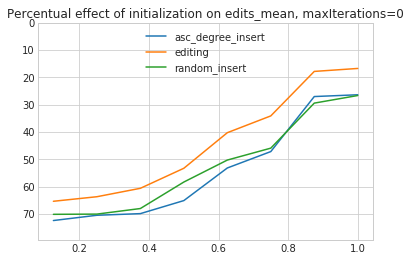

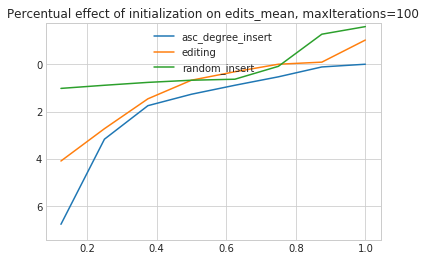

optimum\_delta\_percentual depending on initialization
        graph  maxIterations     n  asc_degree_insert  editing  trivial  \
0      lesmis              0    77               0.17     0.67     3.23   
1      lesmis            100    77               0.03     0.00     0.04   
2   grass_web              0    75                NaN      NaN      NaN   
3   grass_web            100    75                NaN      NaN      NaN   
4      karate              0    34               0.10     0.29     2.71   
5      karate            100    34               0.00     0.00     0.00   
6     adjnoun              0   112                NaN      NaN      NaN   
7     adjnoun            100   112                NaN      NaN      NaN   
8       email              0  1133                NaN      NaN      NaN   
9       email            100  1133                NaN      NaN      NaN   
10  terrorist              0    62                NaN      NaN      NaN   
11  terrorist            100    62           

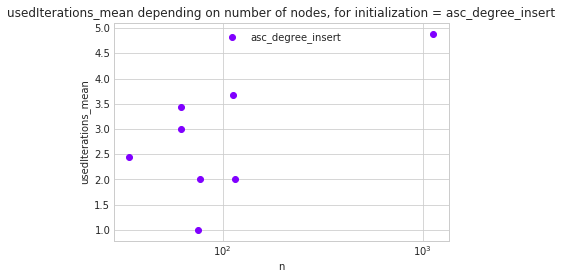

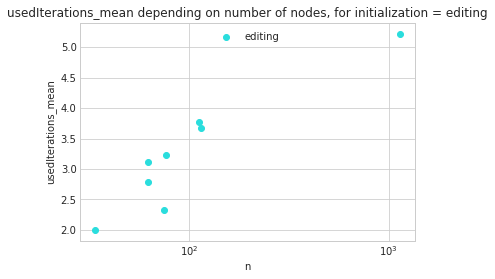

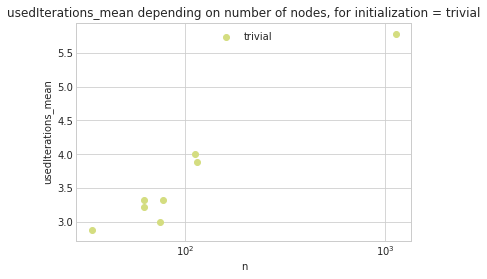

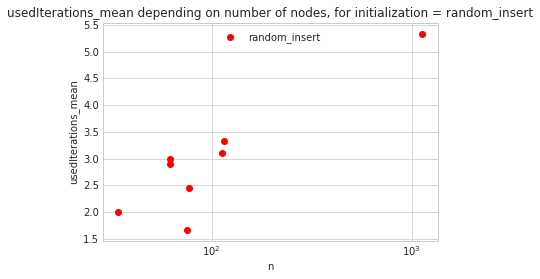

time\_mean depending on initialization
       index     n  asc_degree_insert  editing  trivial  random_insert
0     lesmis    77               0.13     0.15     0.03           0.14
1  grass_web    75               0.10     0.12     0.03           0.10
2     karate    34               0.05     0.07     0.02           0.07
3    adjnoun   112               0.22     0.21     0.04           0.23
4      email  1133               3.02     2.20     0.40           3.16
5  terrorist    62               0.10     0.12     0.03           0.11
6   dolphins    62               0.10     0.12     0.03           0.11
7   football   115               0.28     0.27     0.04           0.29
Average effect of initialization on time\_mean
          index  asc_degree_insert  editing  random_insert
0  small_graphs              -0.42    -0.33          -0.45
edits\_mean depending on sortPaths
        graph maxIterations asc_degree_insert          random_insert         
                                        Fals

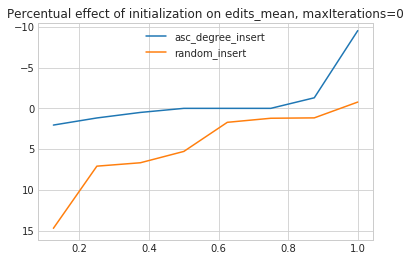

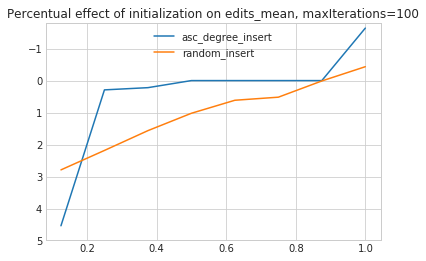

edits\_mean depending on randomness
        graph  maxIterations     n    False     True
0      lesmis              0    77    70.00    71.67
1      lesmis            100    77    62.00    62.00
2   grass_web              0    75    34.00    34.00
3   grass_web            100    75    34.00    34.00
4      karate              0    34    23.00    25.44
5      karate            100    34    21.00    21.00
6     adjnoun              0   112   313.00   313.44
7     adjnoun            100   112   289.56   279.89
8       email              0  1133  3979.00  3991.56
9       email            100  1133  3740.56  3662.78
10  terrorist              0    62    53.00    53.22
11  terrorist            100    62    46.00    46.00
12   dolphins              0    62    84.00    84.00
13   dolphins            100    62    74.89    70.78
14   football              0   115   287.00   287.00
15   football            100   115   251.00   250.00
Average percentual effect of randomness on edits\_mean
        

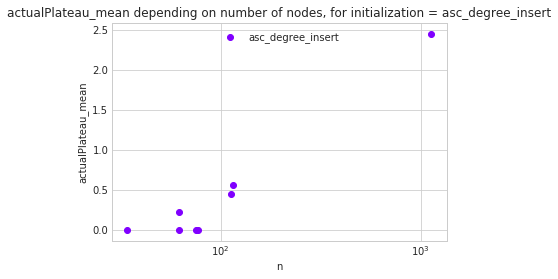

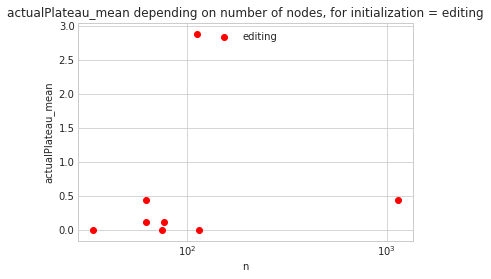

bq\_effect depending on initialization
        graph  maxIterations     n  asc_degree_insert  editing  trivial  \
0      lesmis              0    77              -0.03    -0.03    -0.01   
1      lesmis            100    77               0.11    -0.21    -0.05   
2   grass_web              0    75               0.13     0.09     0.01   
3   grass_web            100    75               1.17     1.51     1.00   
4      karate              0    34               1.57     1.43     0.23   
5      karate            100    34              14.45    15.05    14.88   
6     adjnoun              0   112               0.20     0.19     0.03   
7     adjnoun            100   112               2.10     1.73     2.28   
8       email              0  1133              -2.47    -1.67    -0.31   
9       email            100  1133             -19.44   -19.44   -20.38   
10  terrorist              0    62               0.09     0.07     0.01   
11  terrorist            100    62               0.24     0.8

In [238]:
#addInformation('small_graphs')
plot('small_graphs')